# Chapter 7.2 -- Inspecting a Tree

This notebook deals with the inspecting of the tree.
Until now the tree was just fittend and queried for its density.
No inspection was done.

This file primary shows how the helper structs of the tree are used.

Note the tree in this dimension is rather small.
The reason is that this is a demonstaration that should not to big.


In [1]:
#
# L O A D I N G 
#
# The distributions are implemented in a sub module inside the pyYggdrasil module
import pyYggdrasil.Random as pyR

# We also need the normal part of pyYggdrasil
import pyYggdrasil as pyY

# We also need numpy 
import numpy as np

# We also need plotting
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


# Needed for the gauss kernel
from scipy import stats

In [2]:
# For that we also need an appropriate source of randomness.
geni = pyR.pRNG(42) 

## Making a Tree
First we must create a tree.
For simplicity we will use a one D example.
This is done primarly for the sake of demonstration.
Everything that is showed here can also be used in more than one dimensions.

In [3]:
#
# We will use an outlier distribution.
distri = pyY.Random.Outlier(
    alpha = 0.9,          # Sterength of the first mode
    mean = 0.0,           # Mean of BOTH modes
    sigma1 = 1,           # Standard diveation of the first mode
    sigma2 = 0.1,         # Standard diveation of the second mode
    domain = pyY.HyperCube(1, pyY.Interval(-5.0, 5.0))
)

In [4]:
#
# First we need samples

# Number of samples we use for fitting
aRealyLargeNumberOfSamples = 20000

# Generate the samples
fitSamples = distri.generateSamplesCollection(geni, aRealyLargeNumberOfSamples)

In [5]:
#
# Set up the tree builder
b = pyY.TreeBuilder(pyY.eParModel.LinModel).setGOFLevel(0.0001).setIndepLevel(0.0001).useMedianSplitter()

# Print the builder
print("We will use the builder:")
print(b)

We will use the builder:
ParModel: Linear
Independence Test: Chi2;  \alpha = 0.0001
GOF Test: Chi2;  \alpha = 0.0001
Splitting: Median/Score


In [6]:
#
# Generate the tree
tree = pyY.DETree(domain = distri.getSampleDomain(), builder = b, samples = fitSamples)

### Plot of the Result
For the sake of completness, we will generate a small plot.
Note that this part is not directly applicable to higher dimensions.

In [7]:
# Generate the sample for the plotting
grid = pyY.generateGrid(domain = distri.getSampleDomain(), p1 = 50000, woLowest = True)

In [8]:
# Evaluate the exact pdf and the tree at the plotting points
gridPDF_tree = tree.evaluateSamplesAt(grid)  # We use the _err version, since we did not specify beQuiet

In [9]:
# Evaluate the exact pdf
gridPDF_exac = distri.pdf(grid)

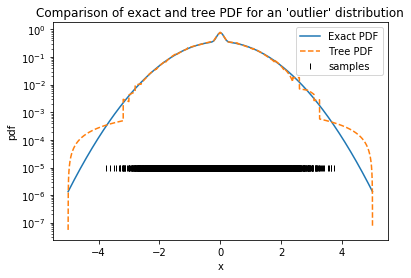

In [10]:
#
# Now we do the actuall plotting

# Get the points that we need
x_plot = grid.getDimensionArray(0)

# Generate the lines
plt.plot(x_plot, gridPDF_exac, label="Exact PDF")
plt.plot(x_plot, gridPDF_tree, '--', label="Tree PDF")
#plt.hist(fitSamples.getDimensionArray(0), bins='auto', density=True, label="Fitt Histogram")
plt.plot(fitSamples.getDimensionArray(0), [0.00001]*len(fitSamples), '|', color='k', label="samples")

# Setting some helper stuff
plt.title("Comparison of exact and tree PDF for an 'outlier' distribution")
plt.xlabel("x")
plt.ylabel("pdf")
plt.yscale("log")
plt.legend()

# Display the image
plt.show()

## Accessing the Nodes
Now after the creation of the tree, we will access the internal structure of the tree.
You have to keep in mind, that pyYggdrasil belifs in exerting tight controll.
Thus only a small part of the inner working can be exposed to the user.
This part is largen in C++, but still limited.

### Examine the Inner Structure
How we will examine the inner structure of the tree.
For that the tree has several methods, that allows to inspect it.


#### Tree Composition
The tree has three kinds of nodes.

The first kind is the leaf.
These are the nodes that are at the bottom of the tree.
They have tests that did not rejected the null hypothesis.
Technically this can also due to the size restrictions, but this is fairly uncommon.
Also in principle they contain samples, however they can also have no samples.

The second kind of nodes are the true splits.
These are former leafs, that where split, because a test was rejected.
The do not have any samples in their collection.

The last kind of nodes are the indirect splits.
These are artificaial nodes, that are introduced when a leaf is split in more than two nodes.
They are always associated to a true split.
Currently each node will be split either into two or four new tentative leafs (six if you count the nodes which also includes the indirect splits).
In priniciple the code can handle more of them.


The tree allows to access the number of the nodes.
This can be usefull for debugging but also to understand strange behaviour.
The count is returned as a triple first the number of true splits, second the number of indirect splits and thrid we have the number of leafs.

In [11]:
#
# Accessing the composition
nTrueSplits, nIndiSplits, nLeafs = tree.getTreeComposition()

In [12]:
# Print it
print("The tree composition is as follows:")
print("   Total Nodes:     {}".format(tree.nNodes()))   # Short hand for optaining the sum of the three 
print("   True splits:     {}".format(nTrueSplits))
print("   Indirect splits: {}".format(nIndiSplits))
print("   Leafs:           {}".format(nLeafs))

The tree composition is as follows:
   Total Nodes:     47
   True splits:     23
   Indirect splits: 0
   Leafs:           24


### The Depth Map
A bit more informative than the tree composition is the depth map.
As the name indicates it has to do with a depth, to be precise it deals with the depth of leafs.
The depth of a leaf is the number of descend operations that are needed to reach it from the root node.
Technically every node has a depth, but only the one of the leafs can be accessed.

#### Generating the Map
A depth map can be generated quiet easaly.

A depth map is a relativly strange object.
It supports the __getiten__(self, i) operator.
This operator will return the number of leafs that has a depth of i.
Since there could be several depth levels with no leaf using it is very inefficient.

To counter that the getIthDepth(i) is provided.
It returns a pair, where first is the depth and second the number of leafs with that depth.
i is not a depth but an index, it starts at zero and goes up to nDiffDepth() - 1.
A list off all different depths, but not their counts can be optained by getDiffDepth().

The map can be transformed into a Python dict, by calling getDict() on the map.

In [13]:
# Generating the map
dMap = tree.getDepthMap()

In [14]:
# Now we look at the provided functions
#help(dMap)

In [15]:
# Now lest see if the depth map works
if(dMap.getLeafCount() == nLeafs):
    print("Both the tree composition and the depth map returns the same number of leafs, {}.".format(nLeafs))
else:
    raise("Serious truble")

Both the tree composition and the depth map returns the same number of leafs, 24.


In [16]:
#
# Now lets take a closer look
print("The mean depth of the tree is:          {}".format(dMap.getDepthMean()))
print("The standard deviation of the depth is: {}".format(dMap.getDepthStd()))
print("The deepest Leaf was at:                {}".format(dMap.getDepthMax()))

The mean depth of the tree is:          6.666666666666667
The standard deviation of the depth is: 2.9814239699997196
The deepest Leaf was at:                11


In [17]:
# It is also possible to access the depths directly
# This is rather clumsy and will be shown here.
# Also note that it is not possible to iterate over the map directly.
# 
# Note that the object can be converted into a dict by calling getDict() on it.
# We use another approace here.
#
# Note that the map would provide getDepthSequence() which would be equivalent to the code here.

# This is a vector for storing the series
depthSeq = np.zeros(nLeafs)
c = 0   # This is a counter

# iterate over the depths
for i in range(len(dMap)):
    # This function returns a pair.
    # First is the depth, and second is the number of times this
    # Depth was observed
    ithDepth, nLeafsInDepth = dMap.getIthDepth(i)
    
    # Filling the array
    for i in range(nLeafsInDepth):
        depthSeq[c] = ithDepth
        c += 1
    
# end for(d):


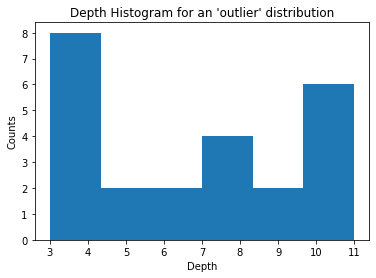

In [18]:
#
# Now we can make a histogram of the sequence
#
plt.hist(depthSeq, bins='auto', density=False)

# Setting some helper stuff
plt.title("Depth Histogram for an 'outlier' distribution")
plt.xlabel("Depth")
plt.ylabel("Counts")

# Display the image
plt.show()

## Iteration over the Leafs
The leafs can also be inspected by iterating over them.
For that pyYggdrasil provides the pyYggdrasil.LeafIterator type.
The tree does overload the __iter__ function and thus allows the iteration in a Python like mannor.

### Over what do I iterate?
A good question, the short answer is not over nodes nor leafs.
This sound very strange but it is true, in a sense.
Even in C++ it is not possible to accessing the nodes directly.
In cases where accessing the nodes is needed a wrapper is used.
This wrapper is of type pyYggdrasil.NodeFacade.

In C-speak it can be compared as a constant pointer to a constant node.
It implements some of the important member fucntions of the node by just wrapping it.
Hower only const methods are allowed.
This preservs the inner consistency of the node.
In C++ the class offers a broader scope than in Python, but there one focuses on other work.


In [19]:
#
# We will now iterate over the leafs and output thier volume.

c = 0             # This is a counter
totVol = 0.0      # This is the total volume

print("Iterating over all the leafs:")
for node in tree:
    c += 1
    nVol = node.getDomain().getVol()
    print("    {:>2} -> Node occupies {}, which has a volume of {}.".format(c, node.getDomain(), nVol))
    totVol += nVol   # Sum up the volume
# end for(node)

print()
print("We have seen {} many nodes that occupies a volume of {}".format(c, totVol))


Iterating over all the leafs:
     1 -> Node occupies {[0.000000, 0.181016[}, which has a volume of 0.18101608197340321.
     2 -> Node occupies {[0.181016, 0.199549[}, which has a volume of 0.01853282783709448.
     3 -> Node occupies {[0.199549, 0.220051[}, which has a volume of 0.020502300105273763.
     4 -> Node occupies {[0.220051, 0.239154[}, which has a volume of 0.019102996292103602.
     5 -> Node occupies {[0.239154, 0.263960[}, which has a volume of 0.024805693056102612.
     6 -> Node occupies {[0.263960, 0.290046[}, which has a volume of 0.026086092227027458.
     7 -> Node occupies {[0.290046, 0.319330[}, which has a volume of 0.029283661816404905.
     8 -> Node occupies {[0.319330, 0.352092[}, which has a volume of 0.03276220327817836.
     9 -> Node occupies {[0.352092, 0.391930[}, which has a volume of 0.03983815020802678.
    10 -> Node occupies {[0.391930, 0.441010[}, which has a volume of 0.04907992366381658.
    11 -> Node occupies {[0.441010, 0.477810[}, which h

#### Node Facade
To see what is supported by the node facade, use the help command.

In [20]:
help(pyY.NodeFacade)

Help on class NodeFacade in module pyYggdrasil:

class NodeFacade(pybind11_builtins.pybind11_object)
 |  This is a node facade, this is abasically a proxy that exposes the internal structure of the tree to the user in a controlled mannor. Its main goal is to keep the amount of code that has to be included by user codse to a minimum. It also serves as a way of restricting the access to the internal structure of the tree. It serves as the stable interface of to the tree. In principle this class models a constant pointer to a node, with a restricted sets of fucntions. It is important that this class only allow read access to the node that is wrapped.
 |  
 |  Method resolution order:
 |      NodeFacade
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  getDomain(...)
 |      getDomain(self: pyYggdrasil.NodeFacade) -> pyYg

## Iteration over the Leafs -- The Direct Way
We have seen that the tree fupports the nice Python iteration.
However there are some limitations, that might sound small but they are there.
The first is, that we have no access to the depth of the tree.
The reason is that a node does not have this iteration.
A depth is always relative to a certain node, which can be arbitrary.

In order to get a deeper access, pyYggdrasil provides the iterator itself to the user.
The usage of the iterator is a bit painful and not realy elegant.
The reason is that we must must take care of the iteration our self, Python won't/can do it for you.

pyYggdrasil (or rather pybind11), will instruct the interpreter to keep the tree alive as long as the iterator exists.


### An Advice
Do never access an iterator that is invalid.
It will result in undefined behaviour.

In [21]:
#
# First setp is obtaining an iterator, currently only the tree can give you such an iterator
it = tree.getLeafIterator()

In [22]:
#
# The leaf iterator supports some functions, lets inspect them
help(pyY.LeafIterator)

Help on class LeafIterator in module pyYggdrasil:

class LeafIterator(pybind11_builtins.pybind11_object)
 |  This class offers a leaf iterator. It can be constructed from any node, since pyYggdrasil, restricts the access to nodes, it is only possible to optain one from the root node. This means it only allows to iterate over all nodes and just a special subset. The order in which the leafs are visited are unspecific. It is alo important that this class only allow read access, thus it models a constant iterator.
 |  
 |  Method resolution order:
 |      LeafIterator
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  access(...)
 |      access(self: pyYggdrasil.LeafIterator) -> pyYggdrasil.NodeFacade
 |      
 |      This function returns a node facade of the node that is currently at the head location of the iterator. A

In [23]:
#
# Now we will iterate over the iterator ourself.
# For that we can not use a for loop, but need a while loop.

# Set some helper variable, you should know them
c = 0
totVol = 0.0

print("Manually iterate over the leafs:")
while(it.isEnd() == False):
    # We have to manually access the node facade, this is like dereferencing the pointer in C
    node = it.access()
    c += 1
    nVol = node.getDomain().getVol()
    print("    {:>2} -> Node at depth {}, occupies {}, which has a volume of {}.".format(c, it.getDepth(), node.getDomain(), nVol))
    totVol += nVol   # Sum up the volume
    
    # Important we have to directly advance it
    it.nextLeaf()
# end while loop

print()
print("We have seen {} many nodes that occupies a volume of {}".format(c, totVol))


Manually iterate over the leafs:
     1 -> Node at depth 11, occupies {[0.000000, 0.181016[}, which has a volume of 0.18101608197340321.
     2 -> Node at depth 11, occupies {[0.181016, 0.199549[}, which has a volume of 0.01853282783709448.
     3 -> Node at depth 10, occupies {[0.199549, 0.220051[}, which has a volume of 0.020502300105273763.
     4 -> Node at depth 9, occupies {[0.220051, 0.239154[}, which has a volume of 0.019102996292103602.
     5 -> Node at depth 8, occupies {[0.239154, 0.263960[}, which has a volume of 0.024805693056102612.
     6 -> Node at depth 7, occupies {[0.263960, 0.290046[}, which has a volume of 0.026086092227027458.
     7 -> Node at depth 6, occupies {[0.290046, 0.319330[}, which has a volume of 0.029283661816404905.
     8 -> Node at depth 5, occupies {[0.319330, 0.352092[}, which has a volume of 0.03276220327817836.
     9 -> Node at depth 4, occupies {[0.352092, 0.391930[}, which has a volume of 0.03983815020802678.
    10 -> Node at depth 3, occup

### Now lets also plot more details
We now also plots the domains that where greated by the splitting process.

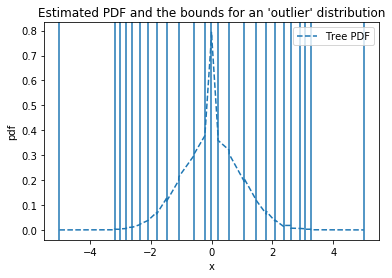

In [24]:
# Get the points that we need
x_plot = grid.getDimensionArray(0)

# Generate the lines
#plt.plot(x_plot, gridPDF_exac, label="Exact PDF")
plt.plot(x_plot, gridPDF_tree, '--', label="Tree PDF")
#plt.plot(fitSamples.getDimensionArray(0), [0.00001]*len(fitSamples), '|', color='k', label="samples")

# Some helper variables
it = tree.getLeafIterator()
lastUpperBound = 0
globalInterval = tree.getGlobalDataSpace()[0]

while(it.isEnd() == False):
    # Load the node
    node = it.access()
    
    # Load the two bounds
    inter = node.getDomain()[0]  # This is the interval of the node, relative to the root data space
    lo = inter.lower()
    up = inter.upper()
    
    # Now we transform the interval bounds from the rescalled root data sapce, to the original data space
    lo_g = globalInterval.mapFromUnit(lo)
    up_g = globalInterval.mapFromUnit(up)
    lastUpperBound = up_g
    
    # Now we add a line for th lower bound
    plt.axvline(x = lo_g)
    
    # Important we have to directly advance it
    it.nextLeaf()
# end while:

# Draw the last Line
plt.axvline(x = lastUpperBound)    

# Setting some helper stuff
plt.title("Estimated PDF and the bounds for an 'outlier' distribution")
plt.xlabel("x")
plt.ylabel("pdf")
#plt.yscale("log")
plt.legend()

# Display the image
plt.show()

### Important
In C accessing a location outside of the array bound can have severe concequences.
Accessing an iterator that has reaced the end is also dangerous.

In [25]:
try:
    it.nextLeaf()
    print("This line will never be printed, becase the iterator is at its end.")
except:
    print("An error was generated, as we tried to increment an iterator ats its end.")

An error was generated, as we tried to increment an iterator ats its end.
